# TikTok - Regression Analysis

This work involves the development and experimental evaluation of a logistic regression model, based on the findinds of the exploratory data analysis (EDA). More specifically, we want to build a regression model using the verification status as the outcome variable in order to examine how different video features are associated with whether a user is verified. Logistic regression is useful for estimating the probability of a certain outcome, especially when multiple variables can influence the outcome. This capability makes it a powerful tool for performing comprehensive and flexible analysis.

In [65]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [67]:
# reading the data
df = pd.read_csv("tiktok_dataset.csv").dropna(axis=0)
df.head(10)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0
5,6,claim,8972200955,35,someone shared with me that gross domestic pro...,not verified,under review,336647.0,175546.0,62303.0,4293.0,1857.0
6,7,claim,4958886992,16,someone shared with me that elvis presley has ...,not verified,active,750345.0,486192.0,193911.0,8616.0,5446.0
7,8,claim,2270982263,41,someone shared with me that the best selling s...,not verified,active,547532.0,1072.0,50.0,22.0,11.0
8,9,claim,5235769692,50,someone shared with me that about half of the ...,not verified,active,24819.0,10160.0,1050.0,53.0,27.0
9,10,claim,4660861094,45,someone shared with me that it would take a 50...,verified,active,931587.0,171051.0,67739.0,4104.0,2540.0


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19084 entries, 0 to 19083
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19084 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19084 non-null  int64  
 3   video_duration_sec        19084 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19084 non-null  object 
 6   author_ban_status         19084 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.9+ MB


In [69]:
df.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19084.000000,1.908400e+04,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9542.500000,5.624840e+09,32.423811,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5509.220604,2.537030e+09,16.226470,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4771.750000,3.425100e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9542.500000,5.609500e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14313.250000,7.840823e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19084.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [70]:
# checking for duplicate values
print("Number of duplicates:", df.duplicated().sum())

# checking class balance
df["claim_status"].value_counts(normalize=True)

Number of duplicates: 0


,proportion
claim_status,
claim,0.503458
opinion,0.496542


In [71]:
def create_box_plot(col_name, title):
    """
    This function creates a boxplot for a given variable in the dataframe.
    """
    plt.figure(figsize=(6,2))
    plt.title(title + " Boxplot", fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    sns.boxplot(x=df[col_name])
    plt.show()


def impute_df_outliers(col_name, iqr_coeff):
    """
    This function imputes upper-limit values in a specified column based on its interquartile range.
    """
    # calculating upper threshold based on quartile values
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    upper_threshold = (iqr_coeff * iqr) + q3
    print(col_name)
    print("Q3:", q3)
    print("Upper Threshold:", upper_threshold)

    # reassigning large values to threshold
    df.loc[df[col_name] > upper_threshold, col_name] = upper_threshold
    print(df[col_name].describe())

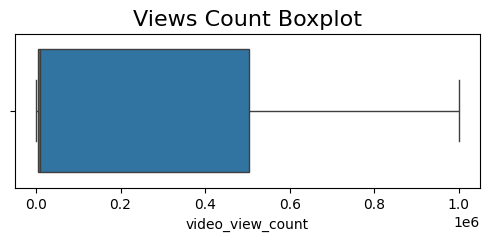

In [72]:
# creating a boxplot for the number of views
create_box_plot("video_view_count", "Views Count")

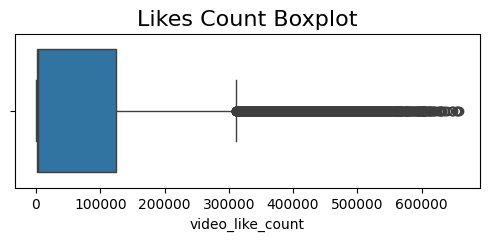

In [73]:
# creating a boxplot for the number of likes
create_box_plot("video_like_count", "Likes Count")

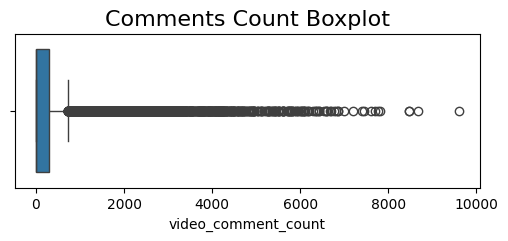

In [74]:
# creating a boxplot for the number of comments
create_box_plot("video_comment_count", "Comments Count")

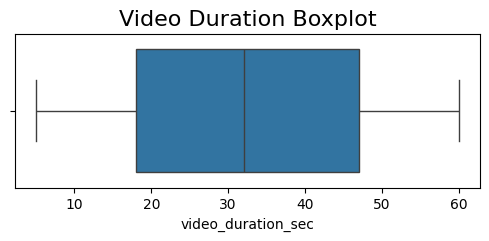

In [75]:
# creating a boxplot for the video duration
create_box_plot("video_duration_sec", "Video Duration")

In [76]:
# imputing the high outliers for the number of likes
impute_df_outliers("video_like_count", 1.5)

video_like_count
Q3: 125020.0
Upper Threshold: 311333.875
count     19084.000000
mean      74323.538632
std      107103.555220
min           0.000000
25%         810.750000
50%        3403.500000
75%      125020.000000
max      311333.875000
Name: video_like_count, dtype: float64


In [77]:
# imputing the high outliers for the number of comments
impute_df_outliers("video_comment_count", 1.5)

video_comment_count
Q3: 292.0
Upper Threshold: 728.5
count    19084.000000
mean       181.023501
std        272.084766
min          0.000000
25%          1.000000
50%          9.000000
75%        292.000000
max        728.500000
Name: video_comment_count, dtype: float64


In [78]:
# checking class balance for the verification status
df["verified_status"].value_counts(normalize=True)

,proportion
verified_status,
not verified,0.93712
verified,0.06288


In [79]:
# using resampling to create class balance in the outcome variable with upsampling
df_majority = df[df["verified_status"] == "not verified"]
df_minority = df[df["verified_status"] == "verified"]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=0)
df_upsampled = pd.concat([df_majority, df_minority_upsampled]).reset_index(drop=True)
df_upsampled["verified_status"].value_counts()

,count
verified_status,
not verified,17884
verified,17884


In [80]:
# getting the average transcript length by verification status
df_upsampled[["verified_status", "video_transcription_text"]].groupby(by="verified_status")[["video_transcription_text"]].agg(func=lambda array: np.mean([len(text) for text in array]))

,video_transcription_text
verified_status,
not verified,89.401141
verified,84.569559


In [81]:
# creating new column for the length of each transcript
df_upsampled["text_length"] = df_upsampled["video_transcription_text"].apply(func=lambda text: len(text))

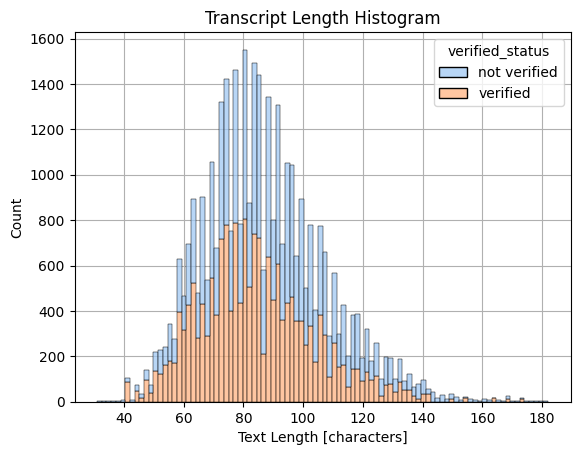

In [82]:
# creating a stacked histogram for the distribution of transcript length
sns.histplot(data=df_upsampled, stat="count",
             multiple="stack",
             x="text_length",
             kde=False,
             palette="pastel",
             hue="verified_status",
             element="bars",
             legend=True,
             zorder=3)
plt.title("Transcript Length Histogram")
plt.xlabel("Text Length [characters]")
plt.ylabel("Count")
plt.grid(zorder=0)
plt.show()

In [83]:
# creating correlation matrix to determine most correlated variables
df_upsampled.corr(numeric_only=True)

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
#,1.000000,-0.000853,-0.011729,-0.697007,-0.626385,-0.504015,-0.487096,-0.608773,-0.193677
video_id,-0.000853,1.000000,0.011859,0.002554,0.005993,0.010515,0.008753,0.012674,-0.007083
video_duration_sec,-0.011729,0.011859,1.000000,0.013589,0.004494,0.002206,0.003989,-0.001086,-0.002981
video_view_count,-0.697007,0.002554,0.013589,1.000000,0.856937,0.711313,0.690048,0.748361,0.244693
video_like_count,-0.626385,0.005993,0.004494,0.856937,1.000000,0.832146,0.805543,0.818032,0.216693
video_share_count,-0.504015,0.010515,0.002206,0.711313,0.832146,1.000000,0.710117,0.671335,0.171651
video_download_count,-0.487096,0.008753,0.003989,0.690048,0.805543,0.710117,1.000000,0.793668,0.173396
video_comment_count,-0.608773,0.012674,-0.001086,0.748361,0.818032,0.671335,0.793668,1.000000,0.217661
text_length,-0.193677,-0.007083,-0.002981,0.244693,0.216693,0.171651,0.173396,0.217661,1.000000


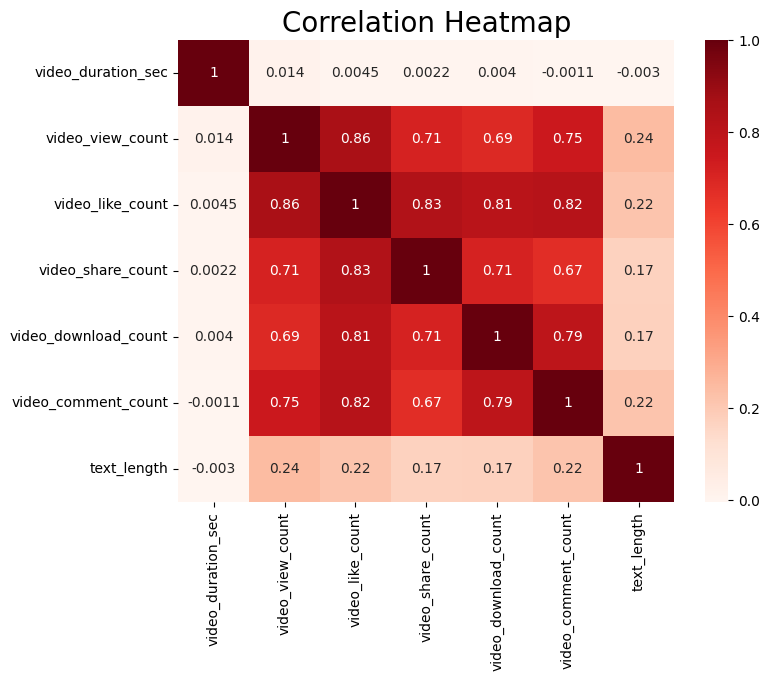

In [84]:
# creating correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_upsampled[["video_duration_sec",
                          "claim_status",
                          "author_ban_status",
                          "video_view_count",
                          "video_like_count",
                          "video_share_count",
                          "video_download_count",
                          "video_comment_count",
                          "text_length"]].corr(numeric_only=True),
            annot=True,
            cmap="Reds")
plt.title("Correlation Heatmap", fontsize=20)
plt.show()

From the heatmap analysis, the number of views and the number of likes show a strong correlation (0.86). To satisfy logistic regression assumptions, the feature for the number of likes is removed to prevent multicollinearity issues. Instead, variables such as `video_view_count`, `video_share_count`, `video_download_count` and `video_comment_count` were retained for model training.

In [85]:
# isolating the features (X) and the target variable (y)
y = df_upsampled["verified_status"]
X = df_upsampled[["video_duration_sec",
                  "claim_status",
                  "author_ban_status",
                  "video_view_count",
                  "video_share_count",
                  "video_download_count",
                  "video_comment_count"]]

# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [86]:
# specifying features for encoding
features_to_encode = ["claim_status", "author_ban_status"]

# one-hot encoder
X_encoder = OneHotEncoder(drop="first", sparse_output=False)

In [87]:
# isolating training features for encoding
X_train_to_encode = X_train[features_to_encode]
X_train_encoded = X_encoder.fit_transform(X_train_to_encode)
X_train_encoded_df = pd.DataFrame(data=X_train_encoded, columns=X_encoder.get_feature_names_out())

# getting final form of training features
X_train_final = pd.concat([X_train.drop(columns=features_to_encode).reset_index(drop=True), X_train_encoded_df], axis=1)
X_train_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,33,2252.0,23.0,4.0,0.0,1.0,0.0,0.0
1,52,6664.0,550.0,53.0,2.0,1.0,0.0,0.0
2,37,6327.0,257.0,3.0,0.0,1.0,0.0,0.0
3,57,1702.0,28.0,0.0,0.0,1.0,0.0,0.0
4,21,3842.0,101.0,1.0,0.0,1.0,0.0,0.0


In [88]:
# isolating testing features for encoding
X_test_to_encode = X_test[features_to_encode]
X_test_encoded = X_encoder.transform(X_test_to_encode)
X_test_encoded_df = pd.DataFrame(data=X_test_encoded, columns=X_encoder.get_feature_names_out())

# getting final form of testing features
X_test_final = pd.concat([X_test.drop(columns=features_to_encode).reset_index(drop=True), X_test_encoded_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,41,2118.0,57.0,5.0,2.0,1.0,0.0,0.0
1,27,5701.0,157.0,1.0,0.0,1.0,0.0,0.0
2,31,449767.0,75385.0,5956.0,728.5,0.0,0.0,0.0
3,19,792813.0,56597.0,5146.0,728.5,0.0,0.0,0.0
4,54,2044.0,68.0,19.0,2.0,1.0,0.0,0.0


In [89]:
# encoding the outcome variable for the training and testing sets
y_encoder = OneHotEncoder(drop="first", sparse_output=False)
y_train_final = y_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_final = y_encoder.transform(y_test.values.reshape(-1, 1)).ravel()

In [90]:
# fitting the logistic regression model to the training data
log_clf = LogisticRegression(random_state=0, max_iter=800).fit(X_train_final, y_train_final)
y_pred = log_clf.predict(X_test_final)

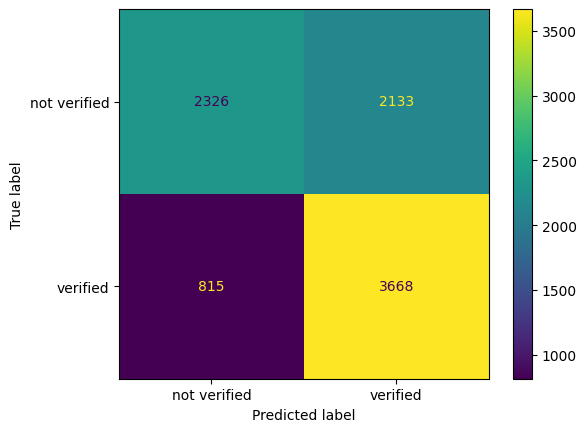

In [91]:
# computing the confusion matrix
log_cm = confusion_matrix(y_test_final, y_pred, labels=log_clf.classes_)

# creating confusion matrix visualization
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=["not verified", "verified"])
log_disp.plot()
plt.show()

We use the following definitions to understand the content of the confusion matrix:

* True Negatives: Correctly classified videos from unverified users.
* False Positives: Unverified users' videos that were incorrectly classified as from verified users.
* False Negatives: Verified users' videos that were incorrectly classified as from unverified users.
* True Positives: Correctly classified videos from verified users.

In an ideal model, there would only be true positives and true negatives, with no false positives or false negatives.


In [92]:
print("Model Accuracy:", accuracy_score(y_test_final, y_pred))

Model Accuracy: 0.6703198389622008


In [93]:
# creating classification report for logistic regression model
print(classification_report(y_test_final, y_pred, target_names=["not verified", "verified"]))

              precision    recall  f1-score   support

not verified       0.74      0.52      0.61      4459
    verified       0.63      0.82      0.71      4483

    accuracy                           0.67      8942
   macro avg       0.69      0.67      0.66      8942
weighted avg       0.69      0.67      0.66      8942



In [94]:
# getting feature names and coefficients from the model
pd.DataFrame(data={"Feature Name":log_clf.feature_names_in_, "Coefficient":log_clf.coef_[0]})

,Feature Name,Coefficient
0,video_duration_sec,-2.410867e-03
1,video_view_count,-1.697628e-07
2,video_share_count,4.891520e-06
3,video_download_count,-8.079698e-05
4,video_comment_count,4.344802e-04
5,claim_status_opinion,1.696512e+00
6,author_ban_status_banned,-4.501341e-01
7,author_ban_status_under review,-1.039178e-01


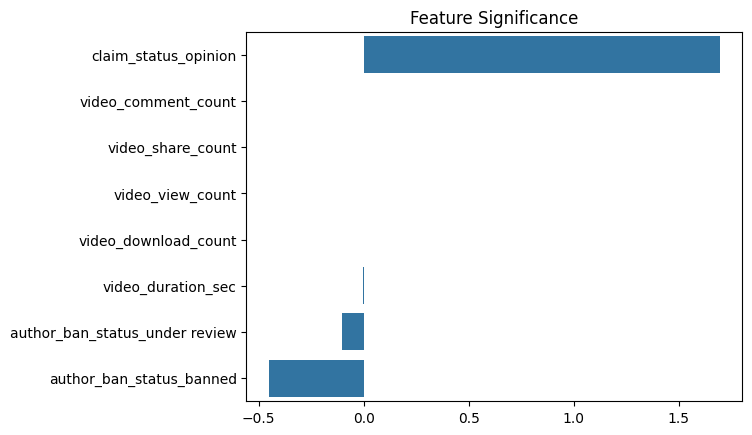

In [95]:
# creating list of tuples for the feature and its coefficient
feature_significance = list(zip(log_clf.feature_names_in_, log_clf.coef_[0]))
feature_significance = sorted(feature_significance, key=lambda x: x[1], reverse=True)

# plotting feature significance
sns.barplot(x=[x[1] for x in feature_significance],
            y=[x[0] for x in feature_significance],
            orient="h")
plt.title("Feature Significance")
plt.show()

Some variables showed strong correlations, posing potential multicollinearity challenges for the logistic regression model. The coefficients indicate that an opinion video increases the log-odds of the user being verified by 1.70 and every additional second of video length decreases the log-odds of the user being verified by 0.002. The model showed moderate predictive performance, with a precision of 63% and a recall of 82%, though its overall accuracy of 67% was slightly lower than ideal. Overall, the model, which predicted the verified status based on video features, demonstrated adequate performance. The analysis highlighted that opinion videos are more likely to be posted by verified users and that banned users are less likely to be verified, whereas other features had less significant associations with verified status.